In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

22/01/24 10:56:46 WARN Utils: Your hostname, pavanlinux resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
22/01/24 10:56:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/24 10:56:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/24 10:56:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
import numpy as np
import pandas as pd                   
import matplotlib.pyplot as plt       
import seaborn as sns
from pyspark.ml.feature import VectorAssembler

In [3]:
df = spark.read.csv("file:///home/pavan-linux/MLib/Logistic Regression/advertising.csv",inferSchema=True,header=True).drop('Timestamp')

In [4]:
df.show(5)

+------------------------+---+-----------+--------------------+--------------------+--------------+----+----------+-------------+
|Daily Time Spent on Site|Age|Area Income|Daily Internet Usage|       Ad Topic Line|          City|Male|   Country|Clicked on Ad|
+------------------------+---+-----------+--------------------+--------------------+--------------+----+----------+-------------+
|                   68.95| 35|    61833.9|              256.09|Cloned 5thgenerat...|   Wrightburgh|   0|   Tunisia|            0|
|                   80.23| 31|   68441.85|              193.77|Monitored nationa...|     West Jodi|   1|     Nauru|            0|
|                   69.47| 26|   59785.94|               236.5|Organic bottom-li...|      Davidton|   0|San Marino|            0|
|                   74.15| 29|   54806.18|              245.89|Triple-buffered r...|West Terrifurt|   1|     Italy|            0|
|                   68.37| 35|   73889.99|              225.58|Robust logistical...|  Sout

In [5]:
df = df.dropna()

In [6]:
df.printSchema()

root
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Area Income: double (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Ad Topic Line: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Clicked on Ad: integer (nullable = true)



In [7]:
df.dtypes

[('Daily Time Spent on Site', 'double'),
 ('Age', 'int'),
 ('Area Income', 'double'),
 ('Daily Internet Usage', 'double'),
 ('Ad Topic Line', 'string'),
 ('City', 'string'),
 ('Male', 'int'),
 ('Country', 'string'),
 ('Clicked on Ad', 'int')]

In [8]:
categorical_columns=['Clicked on Ad','Male']
numeric_columns=[]
for col,datatype in df.dtypes:
    if datatype == 'string':
        categorical_columns.append(col)
    elif col not in categorical_columns:
        numeric_columns.append(col)

In [9]:
categorical_columns

['Clicked on Ad', 'Male', 'Ad Topic Line', 'City', 'Country']

In [10]:
numeric_columns

['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

In [11]:
dataframe = df.toPandas()

In [12]:
x = df.select('Area Income','Age')

In [13]:
y = df.select('Clicked on Ad')

In [14]:
feature = VectorAssembler(inputCols=['Area Income','Age'],outputCol='features')

In [15]:
final_data  = feature.transform(df)

In [16]:
final_data = final_data.select('features','Clicked on Ad')

In [17]:
final_data.show(5)

+---------------+-------------+
|       features|Clicked on Ad|
+---------------+-------------+
| [61833.9,35.0]|            0|
|[68441.85,31.0]|            0|
|[59785.94,26.0]|            0|
|[54806.18,29.0]|            0|
|[73889.99,35.0]|            0|
+---------------+-------------+
only showing top 5 rows



In [18]:
train,test = final_data.randomSplit([0.75,0.25])

In [19]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Clicked on Ad', maxIter=10)
lrModel = lr.fit(train)

22/01/24 10:57:19 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/01/24 10:57:19 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


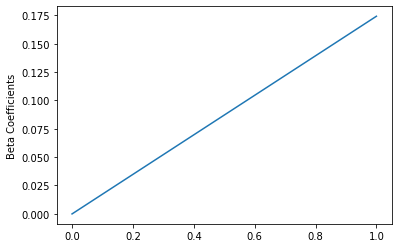

In [20]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

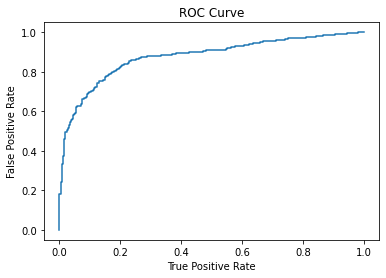

Training set areaUnderROC: 0.8763370786516851


In [21]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

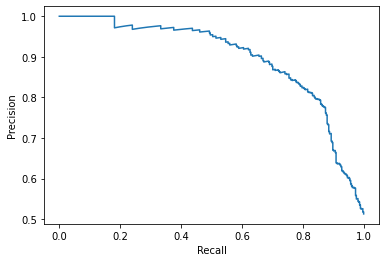

In [22]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [23]:
predictions = lrModel.transform(test)
predictions.show(10)

+---------------+-------------+--------------------+--------------------+----------+
|       features|Clicked on Ad|       rawPrediction|         probability|prediction|
+---------------+-------------+--------------------+--------------------+----------+
|[14548.06,47.0]|            1|[-6.6083633748375...|[0.00134722076126...|       1.0|
|[17709.98,39.0]|            1|[-4.8746213065764...|[0.00758008950786...|       1.0|
|[20592.99,50.0]|            1|[-6.4831307799651...|[0.00152668184356...|       1.0|
|[23821.72,40.0]|            1|[-4.3935566594563...|[0.01220587798851...|       1.0|
|[23942.61,43.0]|            1|[-4.9035943255011...|[0.00736521675282...|       1.0|
|[25371.52,35.0]|            1|[-3.3556932905335...|[0.03370922398797...|       1.0|
|[25408.21,25.0]|            1|[-1.6084207216109...|[0.16680799107565...|       1.0|
|[25583.29,57.0]|            1|[-7.1683277035635...|[7.70016960189449...|       1.0|
|[25686.34,31.0]|            1|[-2.6245980256682...|[0.0675720135

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator().setLabelCol("Clicked on Ad")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8636111111111103
